In [1]:
from git import Repo
import os
import requests

import pandas as pd 
import numpy as np 
import pyarrow.parquet as pq
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
table = pq.read_table('data_granular\gran_data.parquet')
gran_df = table.to_pandas()

In [3]:
gran_df.head()

,donor_id,visit_date,birth_date
0,00000,2013-11-03,1964
1,00000,2014-05-26,1964
2,00000,2015-01-25,1964
3,00000,2015-08-09,1964
4,00000,2016-03-10,1964


In [4]:
#checking null in the dataset
gran_df.isna().sum()

donor_id      0
visit_date    0
birth_date    0
dtype: int64

Theres no null in the dataset

In [5]:
#Check the number of donator in the database
gran_df['donor_id'].nunique()

2244546

In [6]:
gran_df['visit_date'] = pd.to_datetime(gran_df['visit_date'])

In [7]:
sort_gran = gran_df.sort_values(by=['donor_id','visit_date'])

In [8]:
sort_gran['days_between_donations'] = sort_gran.groupby('donor_id')['visit_date'].diff().dt.days
sort_gran['donor_age'] = sort_gran['visit_date'].dt.year-sort_gran['birth_date']
sort_gran

,donor_id,visit_date,birth_date,days_between_donations,donor_age
0,00000,2013-11-03,1964,NaN,49
1,00000,2014-05-26,1964,204.0,50
2,00000,2015-01-25,1964,244.0,51
3,00000,2015-08-09,1964,196.0,51
4,00000,2016-03-10,1964,214.0,52
...,...,...,...,...,...
6237070,09pzv,2024-01-18,2003,NaN,21
6237075,09pzw,2024-01-18,2002,NaN,22
6237076,09pzx,2024-01-18,2005,NaN,19
6237081,09pzy,2024-01-18,1992,NaN,32


In [9]:
sort_gran[sort_gran['birth_date']<=1920]

,donor_id,visit_date,birth_date,days_between_donations,donor_age
16140,000L5,2018-06-17,1900,NaN,118
16141,000L5,2018-12-11,1900,177.0,118
5874076,000L5,2023-06-04,1900,1636.0,123
61905,002wg,2019-01-15,1900,NaN,119
61906,002wg,2019-05-13,1900,118.0,119
...,...,...,...,...,...
5432573,08xn5,2019-01-15,1900,NaN,119
5440314,08yVg,2018-08-09,1900,NaN,118
5437717,08yrv,2019-08-22,1901,NaN,118
5437793,08ysc,2017-10-25,1900,NaN,117


From the age of the donor, we discovered there might be a data entry problem as there are donor who are more thn 100 years old donating the blood.
Thus we will make the rule to only take donor who are from 18 until 65 years old (the max age of eligible to become blood donors) cite from PPUM website.
https://www.ummc.edu.my/pesakit/blood-CRITERIA.asp?kodBM=#:~:text=Age%3A,donor%3A%2018%2D65%20years%20old

In [10]:
#filter the donor age less or equal to 65
sort_gran_fil = sort_gran[sort_gran['donor_age']<=65]
sort_gran_fil


,donor_id,visit_date,birth_date,days_between_donations,donor_age
0,00000,2013-11-03,1964,NaN,49
1,00000,2014-05-26,1964,204.0,50
2,00000,2015-01-25,1964,244.0,51
3,00000,2015-08-09,1964,196.0,51
4,00000,2016-03-10,1964,214.0,52
...,...,...,...,...,...
6237070,09pzv,2024-01-18,2003,NaN,21
6237075,09pzw,2024-01-18,2002,NaN,22
6237076,09pzx,2024-01-18,2005,NaN,19
6237081,09pzy,2024-01-18,1992,NaN,32


To show does Malaysia Retain their blood donater, by looking at the frequency of repeated number of donation.
We generalize all type of donation into blood donation

In [12]:
#group by donor id to get the number of their donations
donor_donations = sort_gran_fil.groupby('donor_id').size().reset_index(name='donation_count')
donor_donations

,donor_id,donation_count
0,00000,11
1,00001,4
2,00002,12
3,00003,5
4,00004,3
...,...,...
2244148,09pzv,1
2244149,09pzw,1
2244150,09pzx,1
2244151,09pzy,1


<Axes: ylabel='Frequency'>

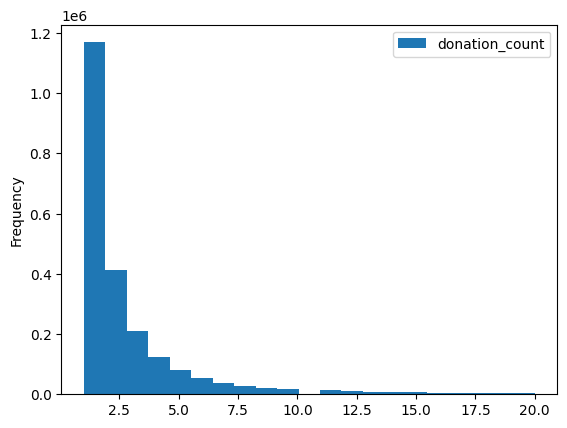

In [27]:
#Plot Histogram for the donation count to see the distribution
donor_donations[donor_donations['donation_count']<=20].plot(kind='hist', bins=21)

Since using histogram does not give much insights except there are a lot of people who are not a repeater for blood donation. Lets try using Pie Chart for two category one time donator and a repeater

In [30]:
#group the donor into repeater or not
repeater = []
for idx,val in enumerate(donor_donations['donation_count']):
    if val > 1:
        repeater.append(True)
    else:
        repeater.append(False)
donor_donations['repeater'] = repeater
donor_donations.head(10)

,donor_id,donation_count,repeater
0,00000,11,True
1,00001,4,True
2,00002,12,True
3,00003,5,True
4,00004,3,True
5,00005,9,True
6,00006,3,True
7,00007,15,True
8,00008,5,True
9,00009,19,True


([<matplotlib.patches.Wedge at 0x1fa26ffdd90>,
 [Text(0.21526005846382334, 3.2929717744356926, 'Repeater'),
  Text(-0.21525975015355314, -3.292971794589779, 'One Time')],
 [Text(0.11741457734390362, 1.7961664224194682, '47.92%'),
  Text(-0.11741440917466534, -1.7961664334126064, '52.08%')])

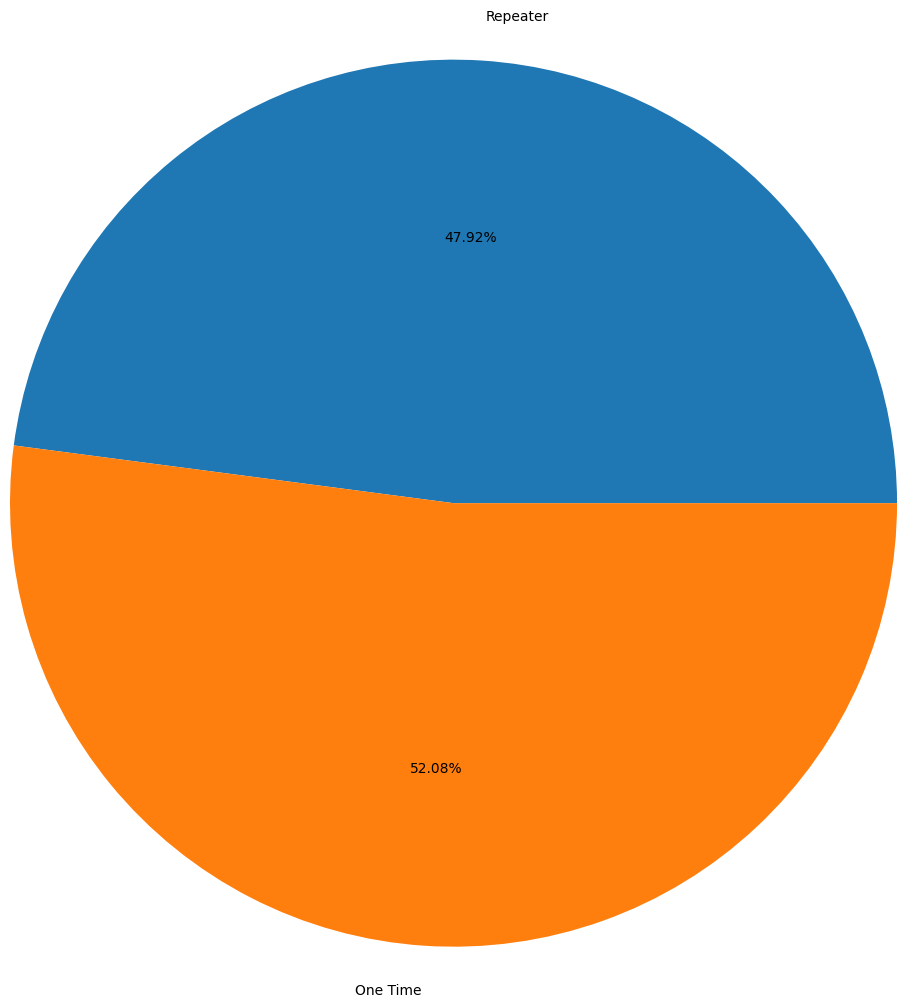

In [102]:
#Plot PieChart for repeater or not
one_time_count = donor_donations[donor_donations['repeater']==False]['repeater'].count()
repeater_count = donor_donations[donor_donations['repeater']==True]['repeater'].count()

fig,ax= plt.subplots()
label = ['Repeater','One Time']
sizes = [repeater_count,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)


In [103]:
#Banding the donation_count
donor_donations[donor_donations['repeater']==True]['donation_count'].quantile(0.7)
first_group = donor_donations[(donor_donations['donation_count']>=2)&(donor_donations['donation_count']<=3)]['donation_count'].count()
second_group = donor_donations[(donor_donations['donation_count']>=4)&(donor_donations['donation_count']<=7)]['donation_count'].count()
third_group = donor_donations[(donor_donations['donation_count']>=8)]['donation_count'].count()

([<matplotlib.patches.Wedge at 0x1fa2702e0d0>,
 [Text(2.116583939414117, 2.531812083748361, '2-3'),
  Text(-1.852480243159175, 2.730991934939561, '4-7'),
  Text(-3.106952528279913, 1.1121357772390286, '8+'),
  Text(-0.21526005846382223, -3.2929717744356926, '')],
 [Text(1.1545003305895183, 1.3809884093172877, '27.84%'),
  Text(-1.0104437689959134, 1.4896319645124874, '13.30%'),
  Text(-1.6947013790617704, 0.6066195148576519, '6.79%'),
  Text(-0.11741457734390302, -1.7961664224194682, '52.08%')])

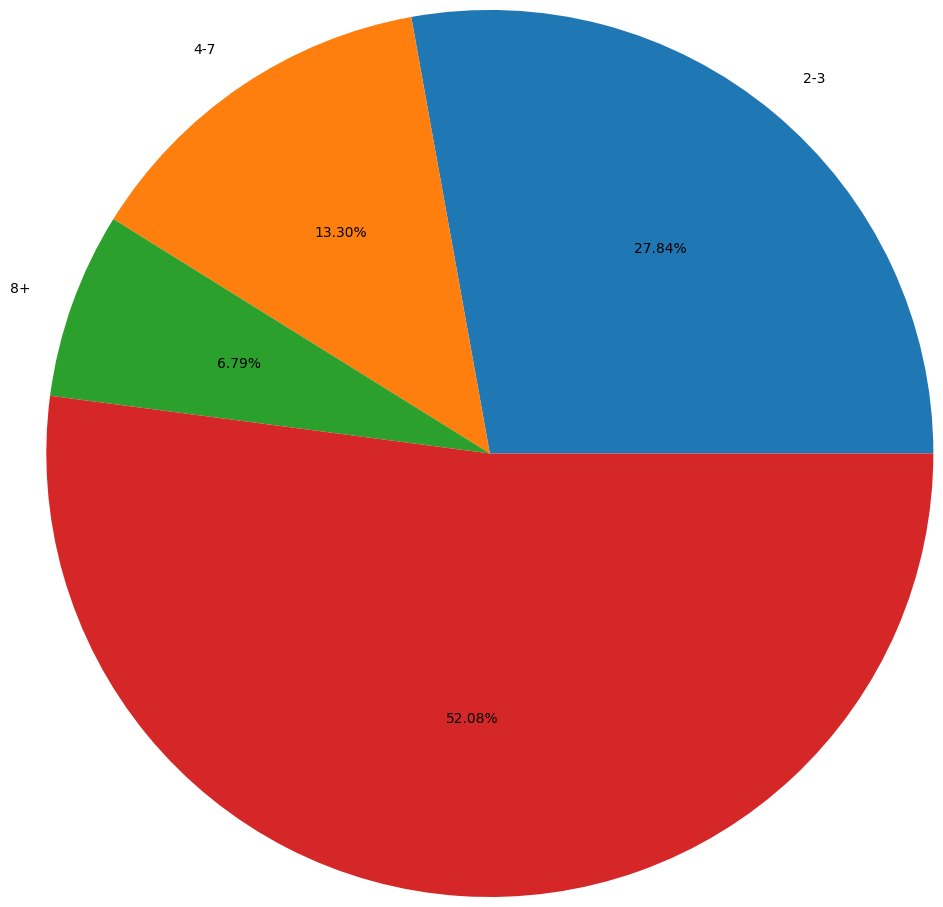

In [104]:
#Pie Chart for the group of Repeater
fig,ax= plt.subplots()
label = ['2-3','4-7','8+','']
sizes = [first_group,second_group,third_group,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)

[None, None, None, None]

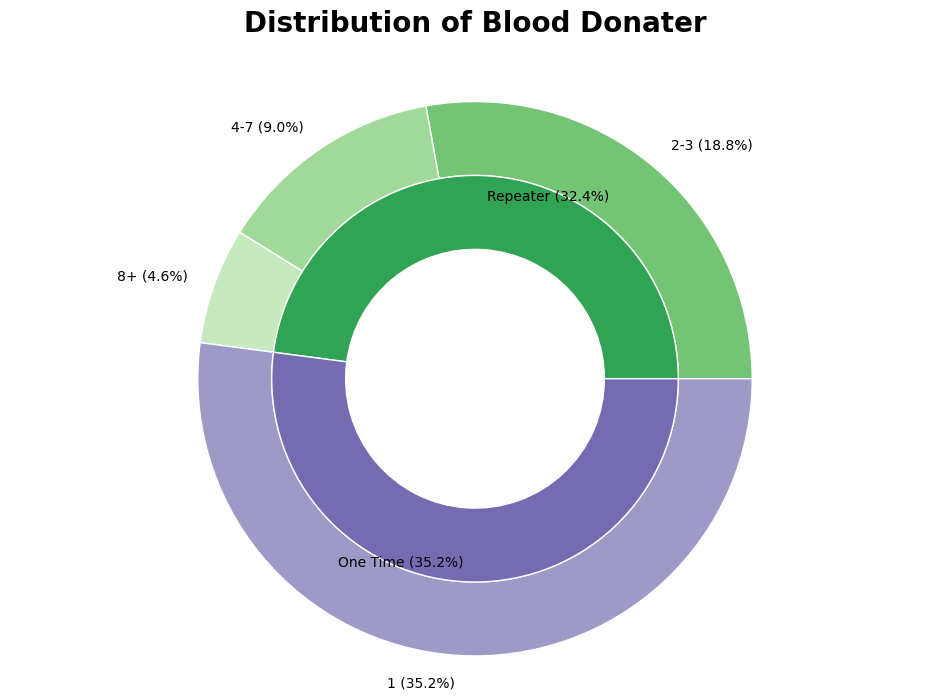

In [161]:
#Plot a two level Pie Chart
fig,ax = plt.subplots(figsize=(12,3))
ax.axis('equal')
width = 0.8

plt.text(0, 4, 'Distribution of Blood Donater', horizontalalignment='center', verticalalignment='top', fontsize=20, weight='bold')

#label and size for outer donut chart
size_out = [first_group,second_group,third_group,one_time_count]
label_out = ['2-3','4-7','8+','1']

#label and size for inner donut chart
label_in = ['Repeater','One Time']
sizes_in = [repeater_count,one_time_count]

# Calculate the total count for the calculation of percentages
total_count = sum(size_out) + sum(sizes_in) - one_time_count  # Subtract one_time_count since it's included twice

# Calculate the percentages for the outer ring
percentages_out = [f"{(size / total_count * 100):.1f}%" for size in size_out]

# Update labels for the outer ring with percentages
label_out_with_perc = [f"{label} ({perc})" for label, perc in zip(label_out, percentages_out)]

# Calculate the percentages for the inner ring
percentages_in = [f"{(size / total_count * 100):.1f}%" for size in sizes_in]

# Update labels for the inner ring with percentages
label_in_with_perc = [f"{label} ({perc})" for label, perc in zip(label_in, percentages_in)]




#Outer Ring (Donation Count Band)
cm = plt.get_cmap("tab20c")

cout = cm(np.array([9,10,11,13]))
pie, _ = ax.pie(size_out, radius=3, labels=label_out_with_perc, colors=cout)
plt.setp(pie, width=width, edgecolor='white',)

#Inner Ring (Repeater Or Not)
cin = cm(np.array([8,12]))
pie2, _ = ax.pie(sizes_in, radius=3-width, labels=label_in_with_perc,
                 labeldistance=0.9, colors=cin,rotatelabels=0)
plt.setp(pie2, width=width, edgecolor='white')

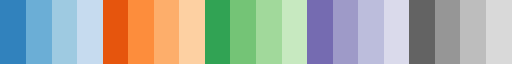

In [153]:
plt.get_cmap("tab20c")

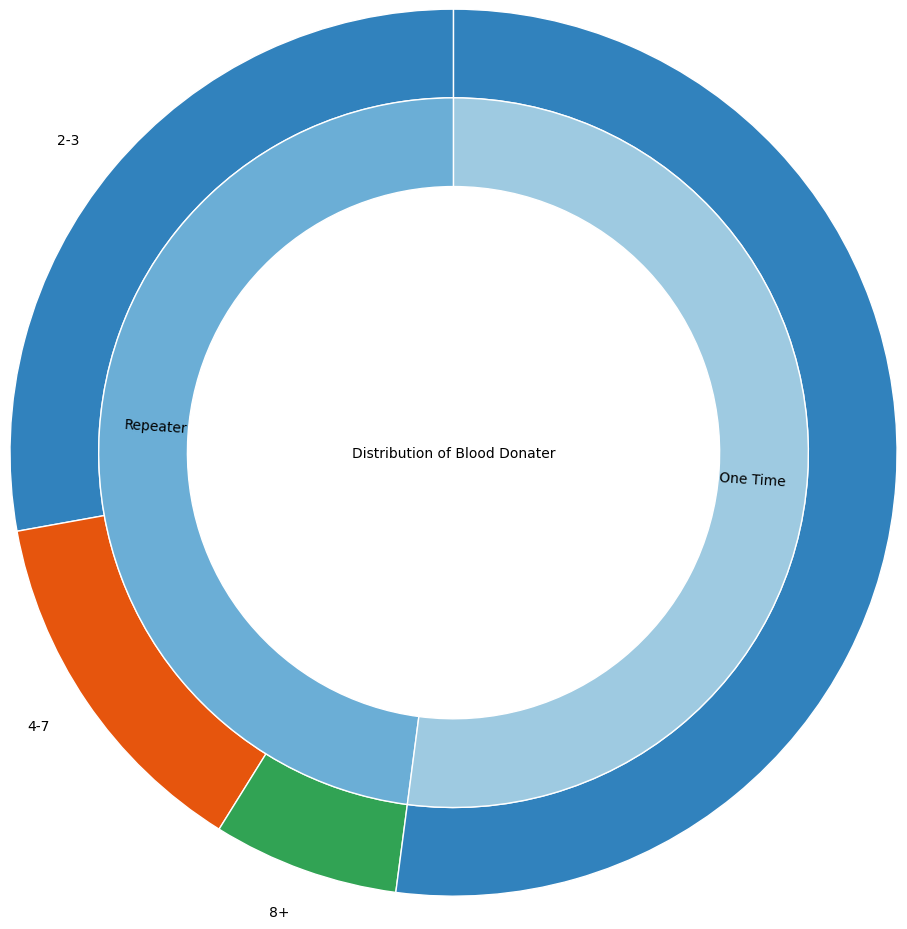

In [124]:

# Plot the two-level pie chart
fig, ax = plt.subplots()
ax.axis('equal')
width = 0.6

# Calculate the total count for the calculation of percentages
total_count = sum([first_group, second_group, third_group, one_time_count, repeater_count]) - one_time_count

# Calculate the percentages for the outer ring
percentages_out = [f"{(size / total_count * 100):.1f}%" for size in [first_group, second_group, third_group, one_time_count]]

# Update labels for the outer ring with percentages
label_out_with_perc = ['2-3', '4-7', '8+', '']  # Removing the 'One Time' label from the outer ring as it will be on the inner ring
sizes_out = [first_group, second_group, third_group, one_time_count]

# Calculate the percentages for the inner ring
percentages_in = [f"{(size / total_count * 100):.1f}%" for size in [repeater_count, one_time_count]]

# Update labels for the inner ring with percentages
label_in_with_perc = ['Repeater', 'One Time']

# Outer Ring (Donation Count Band)
cm = plt.get_cmap("tab20c")
cout = cm(np.arange(3) * 4)
pie, _ = ax.pie(sizes_out, radius=3, labels=label_out_with_perc, colors=cout, startangle=90)
plt.setp(pie, width=width, edgecolor='white')

# Inner Ring (Repeater Or Not)
cin = cm(np.array([1, 2, 5, 6, 9, 10]))
pie2, _ = ax.pie([repeater_count, one_time_count], radius=3 - width, labels=label_in_with_perc, labeldistance=0.75,
                 colors=cin, startangle=90, rotatelabels=True)
plt.setp(pie2, width=width, edgecolor='white')

# Add title in the middle of the pie chart


plt.show()

In [44]:
bins = 30
day_range = max(sort_gran['days_between_donations'].dropna()) - min(sort_gran['days_between_donations'].dropna())
bin_width = day_range / bins


In [45]:
bin_width

146.7

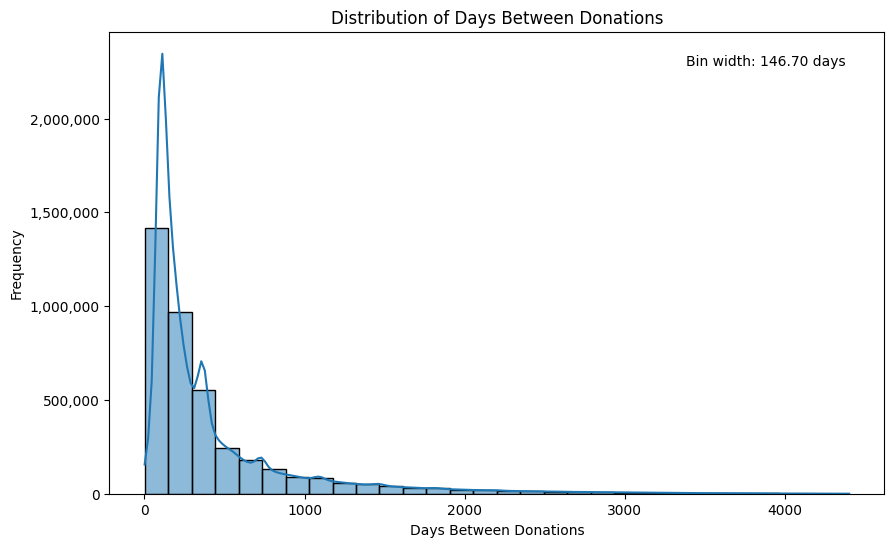

In [46]:
# Plotting the distribution of days between donations
plt.figure(figsize=(10, 6))
ax = sns.histplot(sort_gran['days_between_donations'].dropna(), bins=bins, kde=True)

plt.text(x=0.95, y=0.95, s=f'Bin width: {bin_width:.2f} days',
         horizontalalignment='right',
         verticalalignment='top',
         transform=ax.transAxes,  # This makes the positioning relative to the axes
         fontsize=10)

plt.gca().get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Distribution of Days Between Donations')
plt.xlabel('Days Between Donations')
plt.ylabel('Frequency')
plt.show()

In [56]:
# Calculate the mean days between donations for each donor
donor_intervals = sort_gran.groupby('donor_id')['days_between_donations'].mean().reset_index().dropna()
donor_intervals['days_between_donations']

0           249.900000
1           771.333333
2           332.818182
3           799.750000
4          1442.000000
              ...     
2224851       7.000000
2224955      65.000000
2225285      61.000000
2227946      60.000000
2234185       7.000000
Name: days_between_donations, Length: 1075579, dtype: float64

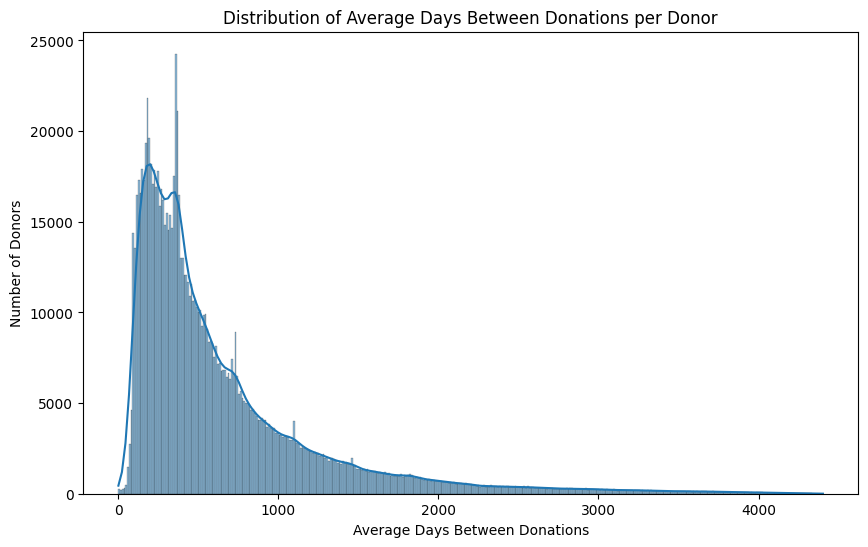

In [63]:
# Now, plot the distribution of average intervals
plt.figure(figsize=(10, 6))
sns.histplot(donor_intervals['days_between_donations'], kde=True)
plt.title('Distribution of Average Days Between Donations per Donor')
plt.xlabel('Average Days Between Donations')
plt.ylabel('Number of Donors')
plt.show()